# Overview

* nb001の続き
* nb001ではnullの変換まで頑張って、長くなってきたのでnb002でつづける

In [87]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import ipdb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [41]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
train_copy = train.copy().reset_index(drop=True)
test_copy = test.copy().reset_index(drop=True)
train_copy["dataset"] = "train"
test_copy["dataset"] = "test"
concat = pd.concat([train_copy, test_copy])
del train_copy, test_copy


# null値が多すぎるのでdropするものたち

drop_null_cols = ["PoolQC", "MiscFeature", "Alley", "Fence"]
concat.drop(columns=drop_null_cols, inplace=True)

# List of 'NaN' including columns where NaN's mean none.
# ここのfeaturesのcolumnのnanは値がないことを示している
none_cols = [
    'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', "Exterior2nd"
]

concat[none_cols] = concat[none_cols].fillna("None")

# ここのcolumnsのnanは値が0であることを示している
zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]
concat[zero_cols] = concat[zero_cols].fillna(0)


# そのほかのnull埋め
# MSZoning, Exterior2nd, Exterior1st -> Neighborhood mode DataLeakage?
# KitchenQual -> BuildMod mode DataLeakage?
# Utilities Electrical Functional SaleType -> mode DataLeakge?

train = concat.iloc[:train.shape[0]].copy()
test = concat.iloc[train.shape[0]:].copy()

from sklearn.impute import SimpleImputer
mode_cols = ["Utilities", "Electrical", "Functional", "SaleType"]
imputer = SimpleImputer(strategy="most_frequent")
train[mode_cols] = imputer.fit_transform(train[mode_cols])
test[mode_cols] = imputer.transform(test[mode_cols])


class mode_by_feature_imputer():
    """
    X_catの値ごとにX_naのmodeを計算し、その値でX_na内のnanを埋める
    X_na: fill値がある値のSeries
    X_cat: その値ごとのX_naの最頻値を算出するためのSeries
    """
    def __init__(self):
        pass
        
    def fit(self, X_na, X_cat):
        na_name = X_na.name
        cat_name = X_cat.name
        df = pd.DataFrame({na_name: X_na, cat_name: X_cat})
        self.dic = df.groupby(cat_name)[na_name].apply(lambda x: x.mode()[0]).to_dict()
        return self
        
    def transform(self, X_na, X_cat):
        ser = X_na.copy()
        ser[ser.isnull()] = X_cat[ser.isnull()].map(self.dic)
        return ser


# data lealage を抑えるためにtrain2のみでBuildRemodYearごとのmodeを計算してそれをtrain, testに適用する
# kitchen_qual_by_year = train2.groupby("YearRemodAdd")["KitchenQual"].apply(lambda x: x.mode()[0]).to_dict()
# train2.loc[train2["KitchenQual"].isnull(), "KitchenQual"] = train2.loc[train2["KitchenQual"].isnull(), "YearRemodAdd"].map(kitchen_qual_by_year)
# test2.loc[test2["KitchenQual"].isnull(), "KitchenQual"] = test2.loc[test2["KitchenQual"].isnull(), "YearRemodAdd"].map(kitchen_qual_by_year)
my_imputer = mode_by_feature_imputer()
my_imputer.fit(X_na=train["KitchenQual"], X_cat=train["YearRemodAdd"])
train["KitchenQual"] = my_imputer.transform(train["KitchenQual"], train["YearRemodAdd"])
test["KitchenQual"] = my_imputer.transform(test["KitchenQual"], test["YearRemodAdd"])

# data lealage MSZoning, Exterior2nd, Exterior1stを抑えるためにtrain2のみでごとのmodeを計算してそれをtrain, testに適用する
for col in ["MSZoning", "Exterior2nd", "Exterior1st", "LotFrontage"]:
    my_imputer = mode_by_feature_imputer()
    my_imputer.fit(X_na=train[col], X_cat=train["Neighborhood"])
    train[col] = my_imputer.transform(X_na=train[col], X_cat=train["Neighborhood"])
    test[col] = my_imputer.transform(test[col], test["Neighborhood"])

# NeighborhoodでLotFrontageもやる

# -------------nb001の内容--------------------------

### categoryの値をconverting

In [88]:
use_features = [col for col in train.columns if col not in ["Id", "SalePrice"]]
cat_features = [col for col in use_features if train[col].dtypes == "object"]
num_features = [col for col in use_features if train[col].dtypes != "object"]
discrete_features = [col for col in num_features if train[col].dtype == "int64"]
countinuous_features = [col for col in num_features if train[col].dtype == "float64"]

concat = pd.concat([train, test])

# for cat in cat_features:
#     val = concat[cat].value_counts().index[0]
#     percent = concat[cat].value_counts().iloc[0] / concat.shape[0] * 100
#     if percent > 95:
#         print(f"{cat:>15}: most freqent value {val:>10} : {percent:.2f}")

#Utilities: most freqent value : 99.90 -> salepriceもこの値ではあまり変動ない -> いらない
concat.drop(columns=["Utilities"], inplace=True)

#LandSlope: most freqent value : 95.17 -> salepriceの変動はあまりないが、関係はありそう -> Otherとして残す
concat["LandSlope"] = np.where(concat["LandSlope"] == "Gtl", concat["LandSlope"], "Other")

# Condition2: most freqent value : 98.97 -> salepriceの変動が大きいがNormが多すぎる -> 全部残す
#RoofMatl: most freqent value : 98.53 -> WdShake, WdShngl は高い傾向 CompShgこれが一番多いが
def encode_RoofMatl(x):
    if x == "CompShg":
        ans = "CompShg"
    elif x in ["WdShake", "WdShake"]:
        ans = "Wood"
    else:
        ans = "Other"
    return ans

concat["RoofMatl"] = concat["RoofMatl"].apply(encode_RoofMatl)

# Heating: most freqent value : 98.46 -> Gasとそれ以外に分ければよいか 2値なら問題ない
concat["Heating"] = concat["Heating"].apply(lambda x: "Gas" if re.match("Gas", x) else "Other")

# order があるcategoricalの値
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'None': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}

ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    concat[col] = concat[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    concat[col] = concat[col].map(fintype_map)

concat['BsmtExposure'] = concat['BsmtExposure'].map(expose_map)

# 2値のものは0 1で変換 ordinal encoderでよい
two_val_cols = ['Street', 'LandSlope', 'Heating', 'CentralAir']
ordinal = OrdinalEncoder()
concat[two_val_cols] = ordinal.fit_transform(concat[two_val_cols])

# 残りはOneHotEncoderかtarget encoding

<AxesSubplot:>

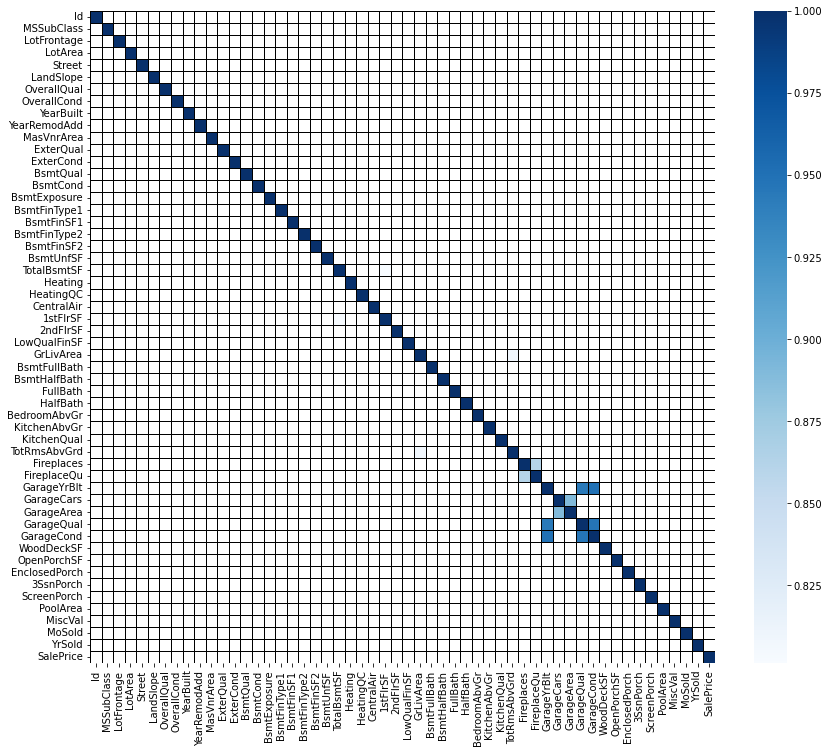

In [104]:
# 連続値の相関を見ておく
num_col = [col for col in concat.columns if concat[col].dtype != "object"]
# fig, ax = plt.subplots(figsize=(14, 12))
# correlation = 
# sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')
cor_mat = concat[num_col].corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cor_mat, mask = cor_mat <0.8, linewidth=1, linecolor="k", cmap='Blues', ax=ax)

## highly correlated features
* FireplaceQu vs Fireplaces
* GarageCars vs GarageArea
* GarageQual vs GarageYrBlt
* GarageCond vs GarageYrBlt
* __Fireplaces, GarageArea, GarageQual, GarageCond__ 落とす

In [105]:
concat.drop(columns=["Fireplaces", "GarageArea", "GarageQual", "GarageCond"], inplace=True)

## 外れ値問題
1. __np.log1pで対数変換__
2. 1%, 99% でclip

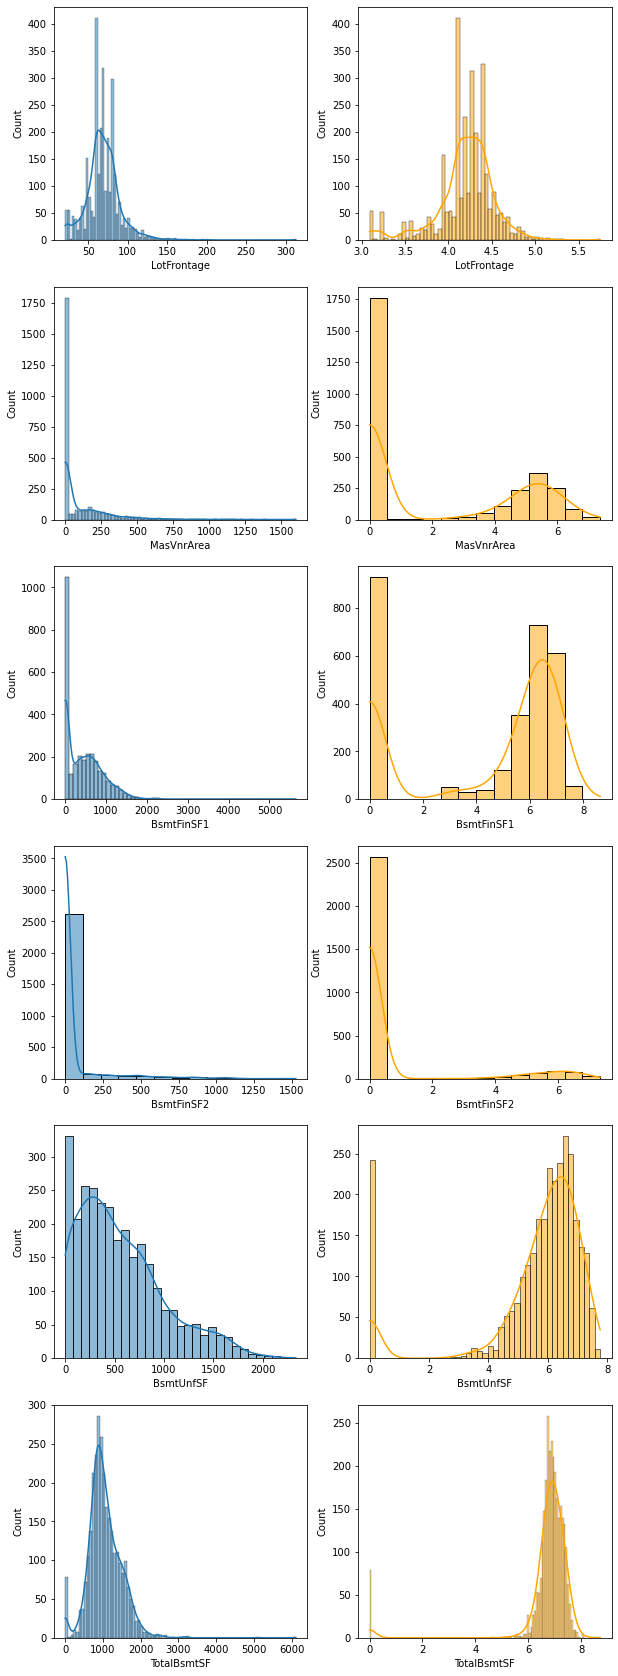

In [128]:
count_features = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]

col = 2
row = len(count_features)

fig, axes = plt.subplots(row, col, figsize=(col * 5, row * 5))

for c in range(col):
    counter = 0
    for r in range(row):
        
        if counter >= len(count_features):
            axes[r, c].set_visible(False)
        else:
            if c % 2 == 0:
                sns.histplot(concat[count_features[counter]], kde=True, ax=axes[r, c])
            elif c % 2 == 1:
                sns.histplot(np.log1p(concat[count_features[counter]]), kde=True, ax=axes[r, c], color="orange")

            counter += 1

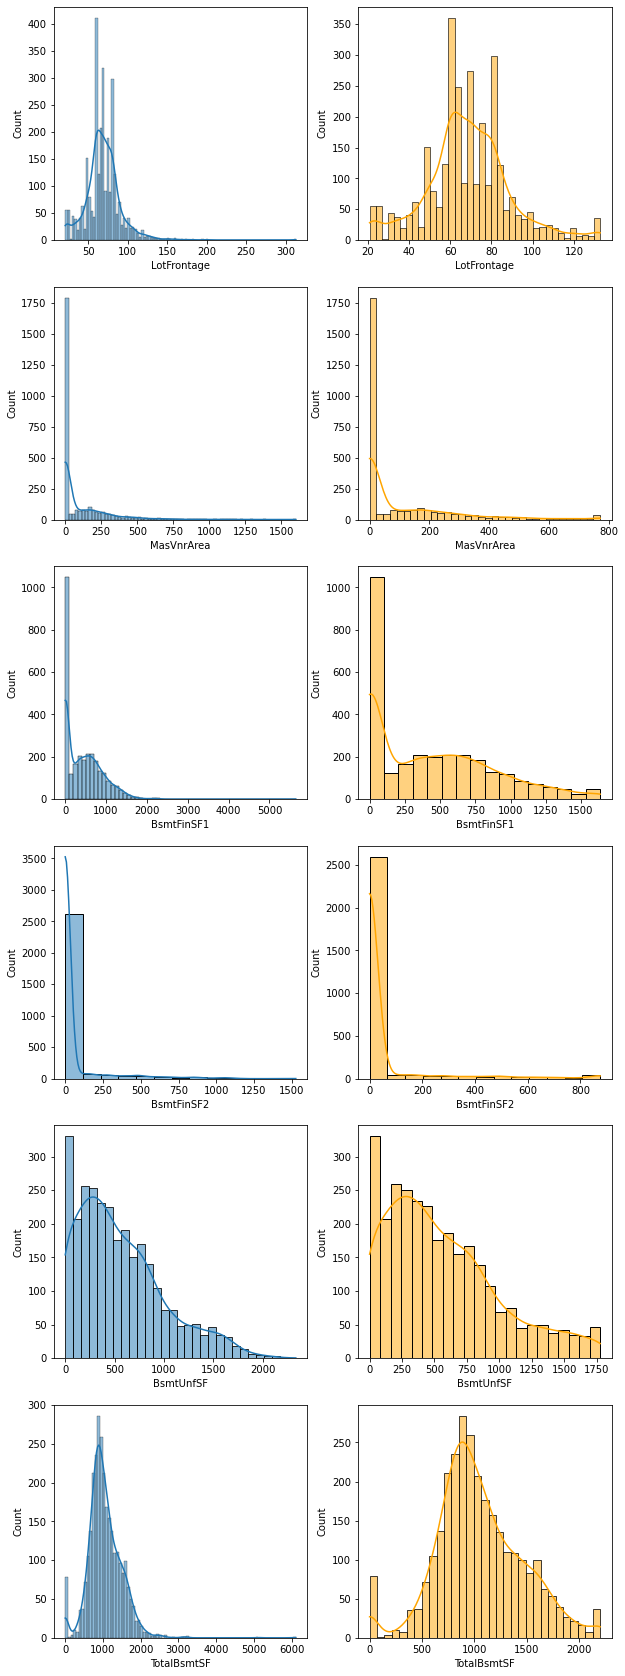

In [129]:
# cliping
count_features = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]

col = 2
row = len(count_features)

fig, axes = plt.subplots(row, col, figsize=(col * 5, row * 5))

for c in range(col):
    counter = 0
    for r in range(row):
        
        if counter >= len(count_features):
            axes[r, c].set_visible(False)
        else:
            if c % 2 == 0:
                sns.histplot(concat[count_features[counter]], kde=True, ax=axes[r, c])
            elif c % 2 == 1:
                ser = concat[count_features[counter]]
                q_1, q_99 = np.percentile(ser, 1), np.percentile(ser, 99)
                sns.histplot(np.clip(ser, q_1, q_99), kde=True, ax=axes[r, c], color="orange")
            
            counter += 1

In [133]:
# 外れ値処理 features target

count_features = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]

for col in count_features:
    ser = concat[col]
    q_1, q_99 = np.percentile(ser, 1), np.percentile(ser, 99)
    concat[col] = np.clip(ser, q_1, q_99)
    
concat["SalePrice"] = np.log(concat["SalePrice"])

In [134]:
concat.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
0,1,60,RL,65.0,8450,1.0,Reg,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706.0,1,0.0,150.0,856.0,0.0,5,1.0,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,Typ,0,Attchd,2003.0,RFn,2.0,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,12.247694,train
1,2,20,RL,80.0,9600,1.0,Reg,Lvl,FR2,0.0,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978.0,1,0.0,284.0,1262.0,0.0,5,1.0,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,Typ,3,Attchd,1976.0,RFn,2.0,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,12.109011,train
2,3,60,RL,68.0,11250,1.0,IR1,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486.0,1,0.0,434.0,920.0,0.0,5,1.0,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,Typ,3,Attchd,2001.0,RFn,2.0,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,12.317167,train
3,4,70,RL,60.0,9550,1.0,IR1,Lvl,Corner,0.0,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216.0,1,0.0,540.0,756.0,0.0,4,1.0,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,Typ,4,Detchd,1998.0,Unf,3.0,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,11.849398,train
4,5,60,RL,84.0,14260,1.0,IR1,Lvl,FR2,0.0,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655.0,1,0.0,490.0,1145.0,0.0,5,1.0,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,Typ,3,Attchd,2000.0,RFn,3.0,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,12.429216,train
